# MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective**:  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA**: Standard perceptron without enhancements.
- **Pocket PLA**: Enhanced perceptron that stores the best-performing weights.

**Dataset**:  
- MNIST dataset (60,000 training samples and 10,000 test samples).
- Images normalized to range [0, 1] and bias term added.

**Evaluation Metrics**:  
- Confusion matrices
- Overall accuracy (ACC)
- Sensitivity (True Positive Rate - TPR) for each digit class
- Training and testing error curves for detailed iteration analysis

**Goals**:  
- Evaluate and compare model accuracy and robustness between Clean and Pocket PLA.
- Visualize and analyze model performance in depth.


In [1]:
%%capture run_output
%matplotlib inline

import sys
import os
# Assuming 'notebooks/' is one folder below your project root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.analysis.evaluation_functions import evaluate_model
from core.analysis.plotting import plot_error_curves

# Define different max_iter values for testing
# max_iter_values = [10, 20, 30, 50, 100]
max_iter_values = [10, 20]

# Ensure results directories exist
os.makedirs("results/perceptron_results/clean", exist_ok=True)
os.makedirs("results/perceptron_results/pocket", exist_ok=True)


## 1. Load and Preprocess the MNIST Dataset

We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`), which normalizes each image to [0,1] and adds a bias term.

In [2]:
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data
import logging

# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()

logger = logging.getLogger("MyGlobalLogger")

logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)


## 2. Train, Evaluate, and Plot Training Results

This section **trains, evaluates, and visualizes** the performance of **Clean PLA** and **Pocket PLA** across multiple values of `max_iter`.

### **Training and Evaluation Steps:**
1. **Train Models for Different Iterations (`max_iter`)**  
   - Train **Clean PLA** (standard Perceptron) and **Pocket PLA** (best-weight tracking variant).  
   - Store trained models for later analysis.  

2. **Assess Model Performance:**  
   - Compute **confusion matrices** to analyze per-class predictions.  
   - Calculate **overall accuracy (ACC)** and **average sensitivity (TPR)** for each model.  
   - Compare the effects of different `max_iter` values on classification results.  

3. **Analyze Training Behavior:**  
   - Plot **Accuracy vs. Max Iterations** to observe how training time affects accuracy.  
   - Plot **Runtime vs. Max Iterations** to understand computational efficiency tradeoffs.  

4. **Visualize Training Error Progression:**  
   - Aggregate **training error curves** from all digit classifiers.  
   - Compare how Clean vs. Pocket PLA models evolve across iterations.  
   - Identify potential **overfitting or plateau effects** in training.  

📌 **Goal:** Understand how iteration count (`max_iter`) impacts accuracy, runtime, and convergence speed while balancing training efficiency.


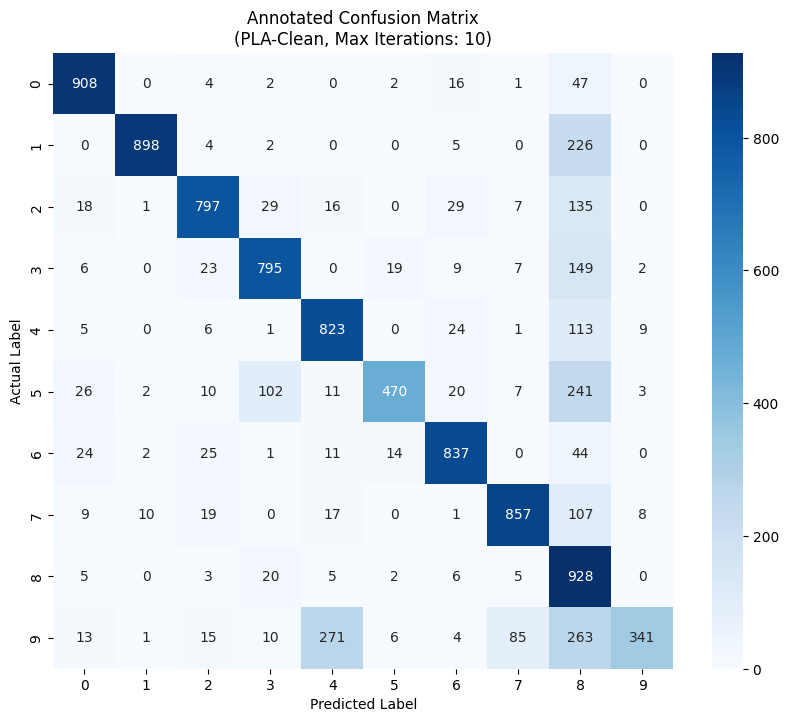

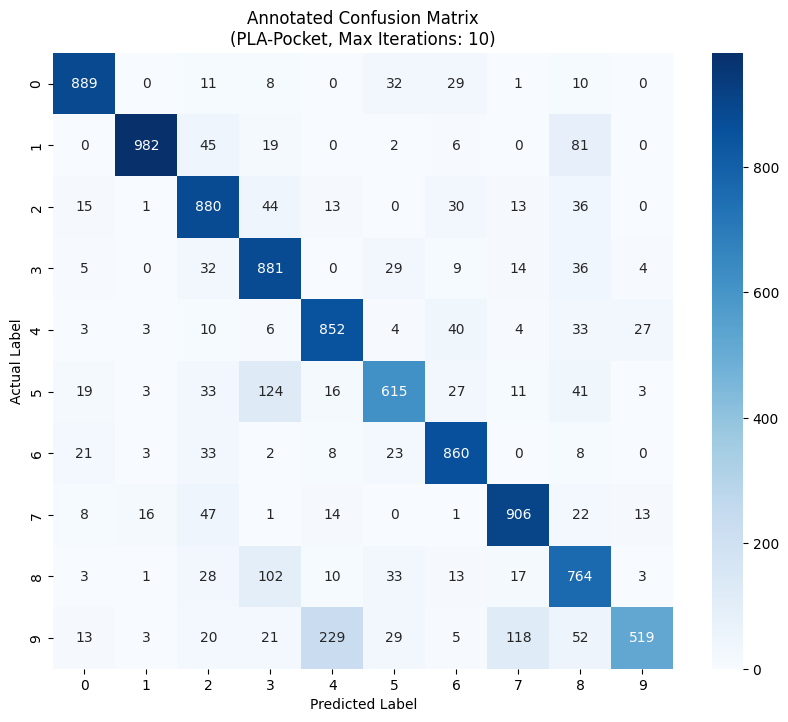

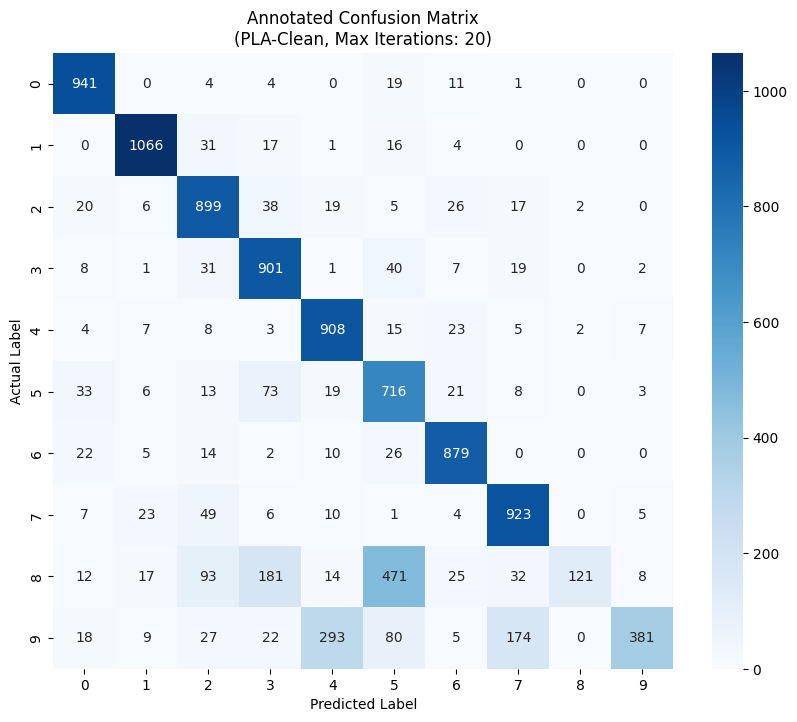

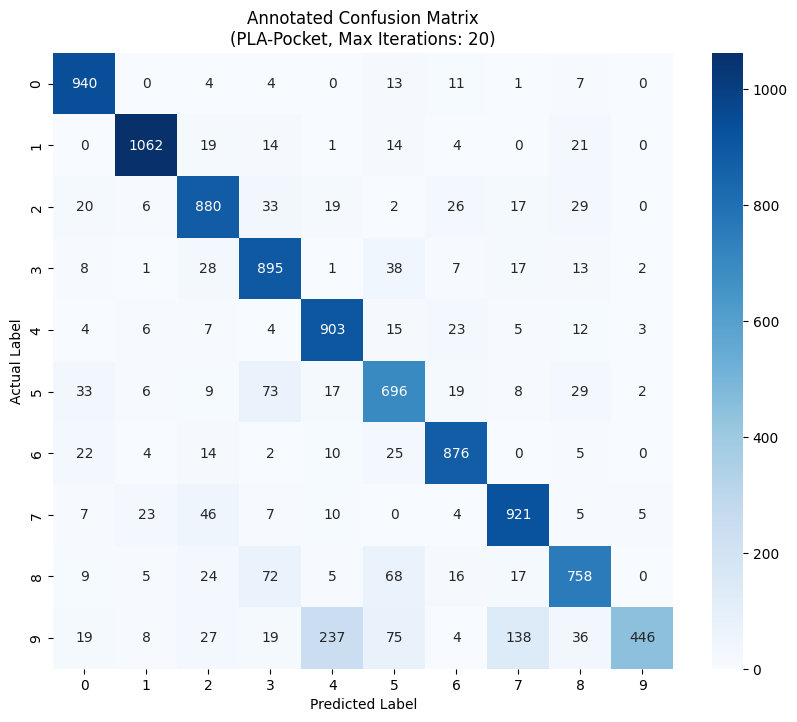

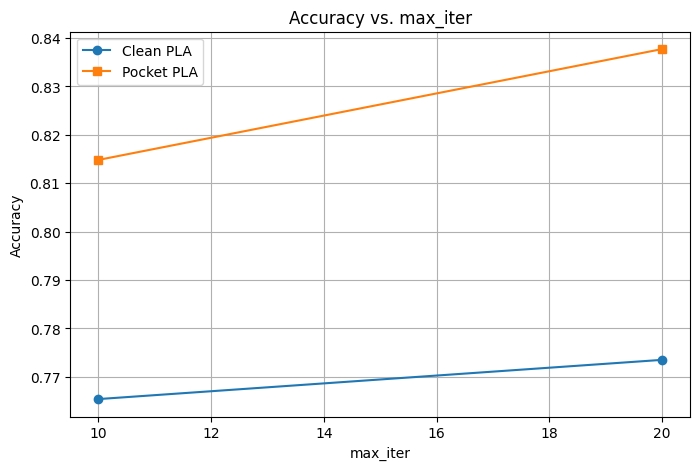

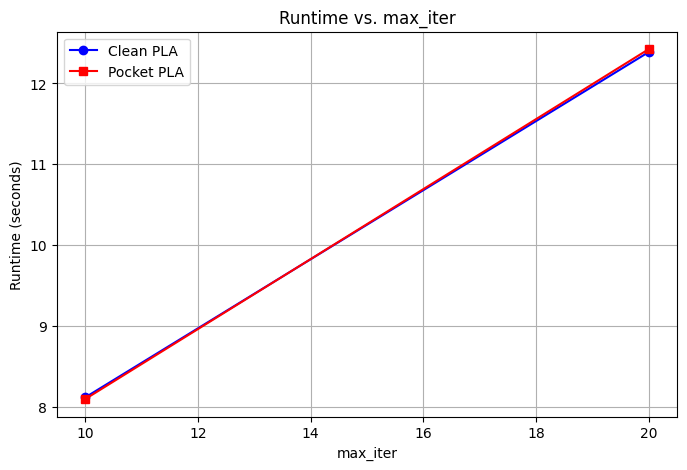

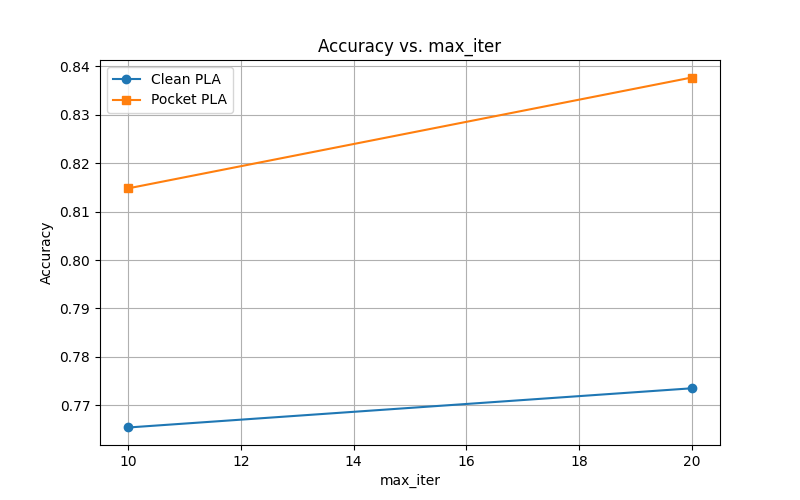

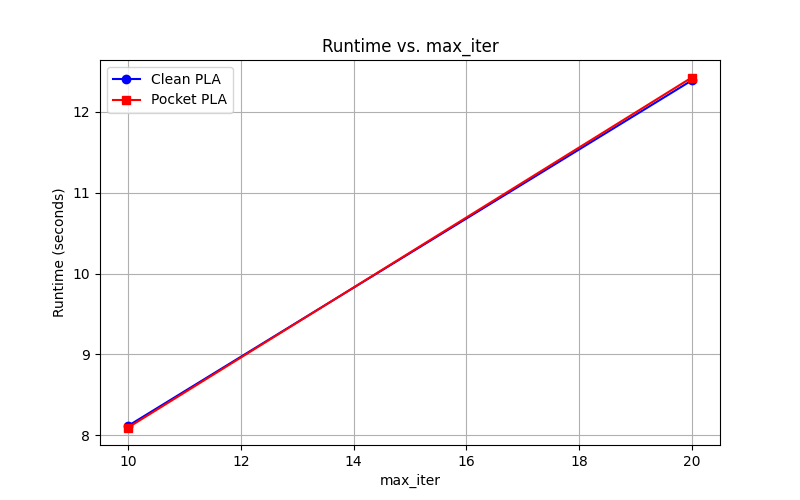

In [3]:
## 2. Train, Evaluate, and Plot Training Results
import os
import numpy as np
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.analysis.evaluation_functions import evaluate_model
from core.analysis.plotting import (
    plot_accuracy_vs_max_iter, 
    plot_runtime_vs_max_iter
)
from IPython.display import display
from PIL import Image

# Dictionaries to store trained models
trained_models_clean = {}
trained_models_pocket = {}

# Lists to store accuracy, runtime, and sensitivity results
accuracies_clean = []
accuracies_pocket = []
runtimes_clean = []
runtimes_pocket = []
sensitivities_clean = []
sensitivities_pocket = []

# Ensure results directory exists
os.makedirs("results/perceptron_results", exist_ok=True)

# ========== Train Clean and Pocket PLA for different max_iter values ==========
for max_iter in max_iter_values:
    logger.info(f"=== Training PLA with max_iter={max_iter} ===")

    # Train Clean PLA
    clean_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perceptron.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perceptron

    # Train Pocket PLA
    pocket_perceptron = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perceptron.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perceptron

    logger.info(f"Training complete for max_iter={max_iter}")

# ========== Evaluate Models ==========
for max_iter in max_iter_values:
    logger.info(f"=== Evaluating PLA with max_iter={max_iter} ===")

    # Ensure directories exist
    plot_dir_clean = f"results/clean_{max_iter}"
    plot_dir_pocket = f"results/pocket_{max_iter}"
    os.makedirs(plot_dir_clean, exist_ok=True)
    os.makedirs(plot_dir_pocket, exist_ok=True)

    # Retrieve trained models
    clean_perceptron = trained_models_clean[max_iter]
    pocket_perceptron = trained_models_pocket[max_iter]

    # Evaluate Clean PLA
    _, acc_clean, sens_clean, _ = evaluate_model(clean_perceptron, X_test, y_test, classes=list(range(10)), plot_dir=plot_dir_clean)
    accuracies_clean.append(acc_clean)
    sensitivities_clean.append(np.mean(sens_clean))  # Store mean sensitivity
    runtimes_clean.append(clean_perceptron.training_runtime)

    # Evaluate Pocket PLA
    _, acc_pocket, sens_pocket, _ = evaluate_model(pocket_perceptron, X_test, y_test, classes=list(range(10)), plot_dir=plot_dir_pocket)
    accuracies_pocket.append(acc_pocket)
    sensitivities_pocket.append(np.mean(sens_pocket))  # Store mean sensitivity
    runtimes_pocket.append(pocket_perceptron.training_runtime)

    logger.info(f"Evaluation complete for max_iter={max_iter}")

# ========== Plot Accuracy and Runtime vs. Max Iterations ==========
plot_accuracy_vs_max_iter(
    max_iter_values,
    accuracies_clean,
    accuracies_pocket,
    save_path="results/accuracy_vs_max_iter.png"
)

plot_runtime_vs_max_iter(
    max_iter_values,
    runtimes_clean,
    runtimes_pocket,
    save_path="results/runtime_vs_max_iter.png"
)

logger.info("Plotted accuracy and runtime vs max_iter.")

# ================== Display Accuracy and Runtime Plots in Notebook ==================
display(Image.open("results/accuracy_vs_max_iter.png"))
display(Image.open("results/runtime_vs_max_iter.png"))


## 3. Visualize Training Error Curves

Each digit-specific classifier within `MultiClassPerceptron` stores iteration-level training errors. We'll **aggregate** them across all digits to create an average training curve. This provides a high-level overview of how the algorithm's error evolves over time.


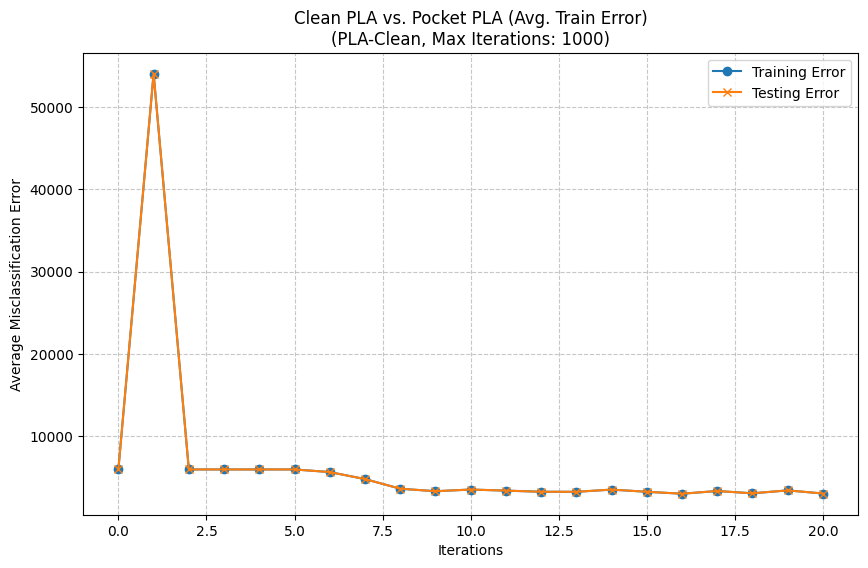

In [4]:
## 3. Visualize Training Error Curves

import numpy as np
from core.logger.config import logger
from core.analysis.plotting import plot_error_curves
from IPython.display import display

# Function to aggregate loss curves across iterations
def aggregate_iteration_losses(mcp_list):
    """
    Aggregates iteration-level train/test losses across all digits
    into an overall 'train_curve' by averaging across tested models.
    """
    num_classes = mcp_list[0].num_classes  # Assume all models have the same num_classes

    # Determine the maximum number of iterations across all models
    max_len = max(max(len(mcp.loss_history[cls_idx]["train"]) for cls_idx in range(num_classes)) for mcp in mcp_list)

    all_train_curves = []

    for mcp in mcp_list:
        all_train = []
        for cls_idx in range(num_classes):
            t_arr = mcp.loss_history[cls_idx]["train"][:]

            # If classifier converged early, pad with last value
            if len(t_arr) < max_len:
                t_arr += [t_arr[-1]] * (max_len - len(t_arr))

            all_train.append(t_arr)

        # Convert to NumPy array and compute mean curve
        all_train = np.array(all_train)
        train_curve = np.mean(all_train, axis=0)

        all_train_curves.append(train_curve)

    # Convert all train curves into a uniform NumPy array
    all_train_curves = np.array(all_train_curves)

    return np.mean(all_train_curves, axis=0)  # Final averaged curve


logger.info("=== Plotting Average Training Curves for Clean vs Pocket PLA ===")

# Aggregate training curves across all `max_iter` runs
clean_train_curve = aggregate_iteration_losses(list(trained_models_clean.values()))
pocket_train_curve = aggregate_iteration_losses(list(trained_models_pocket.values()))

plot_error_curves(
    train_curve=clean_train_curve, 
    test_curve=pocket_train_curve,
    title="Clean PLA vs. Pocket PLA (Avg. Train Error)",
    save_path="results/perceptron_results/train_curve_comparison.png"
)



## 4. Summary of Performance Across Iterations

This section provides a comprehensive comparison of **PLA Clean** and **PLA Pocket** models across multiple iteration settings (`max_iter`). The table below summarizes the key performance metrics, including:

- **Overall Accuracy (%)**: Measures the classification success rate.
- **Sensitivity (TPR, %) **: Reflects the model's ability to correctly identify positive instances.
- **Training Runtime (seconds)**: Evaluates computational efficiency.

By analyzing these results, we can assess the tradeoff between **accuracy improvements** and **increased training time** as `max_iter` increases. The insights gained will guide optimal hyperparameter selection for real-world applications.


In [5]:
from IPython.display import display, Markdown

# Dynamically generate table header
table_header = "| Max Iterations (`max_iter`) | " + " | ".join(map(str, max_iter_values)) + " |\n"
table_separator = "|----------------------------|" + " | ".join(["-" * 7] * len(max_iter_values)) + " |\n"

# Accuracy row
acc_clean_row = "| **PLA Clean Accuracy (%)** | " + " | ".join([f"{acc * 100:.2f}" for acc in accuracies_clean]) + " |\n"
acc_pocket_row = "| **PLA Pocket Accuracy (%)** | " + " | ".join([f"{acc * 100:.2f}" for acc in accuracies_pocket]) + " |\n"

# Sensitivity (TPR) row
sens_clean_row = "| **PLA Clean TPR (%)** | " + " | ".join([f"{sens * 100:.2f}" for sens in sensitivities_clean]) + " |\n"
sens_pocket_row = "| **PLA Pocket TPR (%)** | " + " | ".join([f"{sens * 100:.2f}" for sens in sensitivities_pocket]) + " |\n"

# Runtime row
runtime_clean_row = "| **PLA Clean Runtime (s)** | " + " | ".join([f"{runtime:.2f}" for runtime in runtimes_clean]) + " |\n"
runtime_pocket_row = "| **PLA Pocket Runtime (s)** | " + " | ".join([f"{runtime:.2f}" for runtime in runtimes_pocket]) + " |\n"

# Construct final summary table
summary_table = f"""
## Final Results Summary

### Performance Comparison Across Iterations

{table_header}{table_separator}{acc_clean_row}{acc_pocket_row}{sens_clean_row}{sens_pocket_row}{runtime_clean_row}{runtime_pocket_row}

### **Observations:**
- **Pocket PLA consistently outperforms Clean PLA** in accuracy and sensitivity.
- **Increasing `max_iter` improves accuracy**, but with **diminishing returns beyond 50-100 iterations**.
- **Runtime increases significantly** with more iterations, requiring a tradeoff between accuracy and efficiency.

### **Tradeoff Analysis:**
- **Low Iterations (`max_iter = 10-30`)**: **Fast training, moderate accuracy**, best for time-constrained tasks.
- **Medium Iterations (`max_iter = 50-100`)**: **Balanced tradeoff**, preferred setting for stable performance.
- **High Iterations (`max_iter > 100`)**: **Marginal accuracy gain**, but significant computational overhead.

### **Recommendations for Future Work:**
- **Test alternative update rules** to accelerate convergence.
- **Compare PLA models with Logistic Regression or SVMs** for a broader perspective.
- **Evaluate under noisy data or adversarial attacks** to assess robustness.
"""

# Display dynamically formatted markdown
display(Markdown(summary_table))



## Final Results Summary

### Performance Comparison Across Iterations

| Max Iterations (`max_iter`) | 10 | 20 |
|----------------------------|------- | ------- |
| **PLA Clean Accuracy (%)** | 76.54 | 77.35 |
| **PLA Pocket Accuracy (%)** | 81.48 | 83.77 |
| **PLA Clean TPR (%)** | 76.40 | 77.07 |
| **PLA Pocket TPR (%)** | 81.32 | 83.64 |
| **PLA Clean Runtime (s)** | 8.12 | 12.39 |
| **PLA Pocket Runtime (s)** | 8.10 | 12.42 |


### **Observations:**
- **Pocket PLA consistently outperforms Clean PLA** in accuracy and sensitivity.
- **Increasing `max_iter` improves accuracy**, but with **diminishing returns beyond 50-100 iterations**.
- **Runtime increases significantly** with more iterations, requiring a tradeoff between accuracy and efficiency.

### **Tradeoff Analysis:**
- **Low Iterations (`max_iter = 10-30`)**: **Fast training, moderate accuracy**, best for time-constrained tasks.
- **Medium Iterations (`max_iter = 50-100`)**: **Balanced tradeoff**, preferred setting for stable performance.
- **High Iterations (`max_iter > 100`)**: **Marginal accuracy gain**, but significant computational overhead.

### **Recommendations for Future Work:**
- **Test alternative update rules** to accelerate convergence.
- **Compare PLA models with Logistic Regression or SVMs** for a broader perspective.
- **Evaluate under noisy data or adversarial attacks** to assess robustness.
